# Pyspark for Linear Regression

### 1. Set up spark context and SparkSession

In [4]:
#from pyspark import SparkConf, SparkContext
## set up spark context
#from pyspark.sql import SQLContext
#sc = SparkContext()
#sqlContext = SQLContext(sc)
## set up  SparkSession
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### 2. Load dataset

In [5]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("./data/Advertising.csv",header=True);

In [6]:
df.take(2)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- TV: double (nullable = true)
 |-- Radio: double (nullable = true)
 |-- Newspaper: double (nullable = true)
 |-- Sales: double (nullable = true)



### 3. Convert the data to dense vector

- check the dataset and the Schema

In [7]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

In [8]:
# convert the data to dense vector
#def transData(row):
#    return Row(label=row["Sales"],
#               features=Vectors.dense([row["TV"],
#                                       row["Radio"],
#                                       row["Newspaper"]]))
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

### 4. Transform the dataset to DataFrame

In [9]:
#transformed = df.rdd.map(transData).toDF() 
transformed= transData(df)
transformed.show(6)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,230.1,37.8,6...| 22.1|
|[2.0,44.5,39.3,45.1]| 10.4|
|[3.0,17.2,45.9,69.3]|  9.3|
|[4.0,151.5,41.3,5...| 18.5|
|[5.0,180.8,10.8,5...| 12.9|
| [6.0,8.7,48.9,75.0]|  7.2|
+--------------------+-----+
only showing top 6 rows



### 5. Fit model (Ridge Regression and the LASSO)

In [10]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()

# Fit 2 models, using different regularization parameters
modelA = lr.fit(transformed, {lr.regParam:0.0})
modelB = lr.fit(transformed, {lr.regParam:1.0})

In [11]:
modelA.coefficients

DenseVector([-0.0006, 0.0458, 0.1884, -0.0012])

In [12]:
 modelA.intercept

3.0052094200978514

In [13]:
 # Make predictions
predictionsA = modelA.transform(transformed)
predictionsA.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.0,230.1,37.8,6...| 22.1|20.572514570685502|
|[2.0,44.5,39.3,45.1]| 10.4|12.388462990928932|
|[3.0,17.2,45.9,69.3]|  9.3| 12.35144102556534|
|[4.0,151.5,41.3,5...| 18.5|17.645432513138324|
|[5.0,180.8,10.8,5...| 12.9|13.240524594858073|
| [6.0,8.7,48.9,75.0]|  7.2|12.518668794162874|
|[7.0,57.5,32.8,23.5]| 11.8|11.783016008679457|
|[8.0,120.2,19.6,1...| 13.2|12.180723998491587|
|   [9.0,8.6,2.1,1.0]|  4.8| 3.788025221710791|
|[10.0,199.8,2.6,2...| 10.6|12.608877619721778|
|[11.0,66.1,5.8,24.2]|  8.6|  7.08715352626673|
|[12.0,214.7,24.0,...| 17.4|17.342564342618747|
|[13.0,23.8,35.1,6...|  9.2|10.617452825343557|
| [14.0,97.5,7.6,7.2]|  9.7| 8.883004180325315|
|[15.0,204.1,32.9,...| 19.0|18.479990677337003|
|[16.0,195.4,47.7,...| 22.4|20.860652402722692|
|[17.0,67.8,36.6,1...| 12.5|12.852044750236278|
|[18.0,281.4,39.6,...| 24.4| 23.26671246

### 6. Evaluation

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse")
RMSE = evaluator.evaluate(predictionsA)
print("ModelA: Root Mean Squared Error = " + str(RMSE))

ModelA: Root Mean Squared Error = 1.6682438365932681


In [15]:
predictionsB = modelB.transform(transformed)
predictionsB.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.0,230.1,37.8,6...| 22.1|19.828612153446723|
|[2.0,44.5,39.3,45.1]| 10.4|12.743896164254814|
|[3.0,17.2,45.9,69.3]|  9.3|12.886085216518897|
|[4.0,151.5,41.3,5...| 18.5|17.271268280921475|
|[5.0,180.8,10.8,5...| 12.9|13.628873620827338|
| [6.0,8.7,48.9,75.0]|  7.2| 13.06393451559012|
|[7.0,57.5,32.8,23.5]| 11.8|12.079322352937485|
|[8.0,120.2,19.6,1...| 13.2|12.351214463828724|
|   [9.0,8.6,2.1,1.0]|  4.8| 5.238785191652109|
|[10.0,199.8,2.6,2...| 10.6| 12.82456949643117|
|[11.0,66.1,5.8,24.2]|  8.6| 8.189558569720916|
|[12.0,214.7,24.0,...| 17.4| 16.62906608991127|
|[13.0,23.8,35.1,6...|  9.2|11.421348919147173|
| [14.0,97.5,7.6,7.2]|  9.7| 9.565107125587986|
|[15.0,204.1,32.9,...| 19.0| 17.89351495228149|
|[16.0,195.4,47.7,...| 22.4|  19.9188684480379|
|[17.0,67.8,36.6,1...| 12.5|13.673942272805704|
|[18.0,281.4,39.6,...| 24.4|21.985941097

In [16]:
RMSE = evaluator.evaluate(predictionsB)
print("ModelB: Root Mean Squared Error = " + str(RMSE))

ModelB: Root Mean Squared Error = 1.8387638749471698


### 7. Visualization

In [17]:
# Import numpy, pandas, and ggplot
import numpy as np
from pandas import *
from ggplot import *
 
# Create Python DataFrame
pop = transformed.rdd.map(lambda p: (p.features[0])).collect()
sales = transformed.rdd.map(lambda p: (p.label)).collect()
predA = predictionsA.select("prediction").rdd.map(lambda r: r[0]).collect()
predB = predictionsB.select("prediction").rdd.map(lambda r: r[0]).collect()



pydf = DataFrame([predA]) 
nx,ny = pydf.shape
type1 = Series([0 for x in range(ny)])
type2 = Series([1 for x in range(ny)])

#pydf
# pandas DataFrame    
pydf1 = DataFrame({'pop':pop,'sales':sales,'pred':predA,'type':type1})
pydf2 = DataFrame({'pop':pop,'sales':sales,'pred':predB,'type':type2})

frames = [pydf1, pydf2]

result = concat(frames)
result['type'] = result['type'].astype(object)
result

,pop,pred,sales,type
0,1.0,20.572515,22.1,0
1,2.0,12.388463,10.4,0
2,3.0,12.351441,9.3,0
3,4.0,17.645433,18.5,0
4,5.0,13.240525,12.9,0
5,6.0,12.518669,7.2,0
6,7.0,11.783016,11.8,0
7,8.0,12.180724,13.2,0
8,9.0,3.788025,4.8,0
9,10.0,12.608878,10.6,0


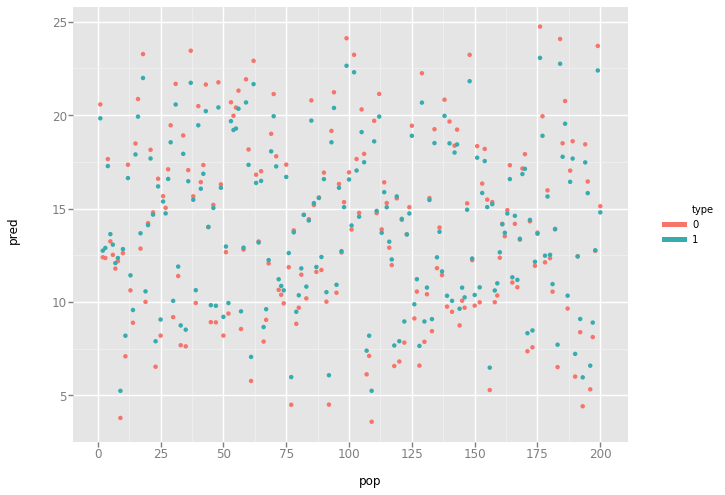

<ggplot: (288183374)>

In [18]:
# Create scatter plot and two regression models (scaling exponential) using ggplot from ggplot import *
ggplot(result, aes(x='pop',y='pred',color='type')) +\
geom_point(colors='blue') 

### 8. More features about the model

- build model

In [19]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression

In [20]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("./data/Advertising.csv",header=True);

In [21]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [22]:
transformed = transData(df)
#transformed.show()

In [23]:
lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal")

In [24]:
model = lr.fit(transformed)

- coefficients

In [25]:
model.coefficients

DenseVector([-0.0006, 0.0458, 0.1884, -0.0012])

- intersection

In [26]:
model.intercept

3.0052094200978514

- summary

In [34]:
def modelsummary(model):
    import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate  Std.Error  t Values  P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary
    
    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))
        
    print ("##",'---')
    print ("##","Mean squared error: % .6f" % Summary.meanSquaredError, ", RMSE: % .6f" % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", Total iterations: %i"% Summary.totalIterations)    

In [35]:
modelsummary(model)

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate  Std.Error  t Values  P-value
##  -0.000580   0.002099   -0.276   0.782681
##   0.045776   0.001399   32.725   0.000000
##   0.188383   0.008648   21.784   0.000000
##  -0.001243   0.005932   -0.210   0.834198
##   3.005209   0.394208    7.623   0.000000
## ---
## Mean squared error:  2.783037 , RMSE:  1.668244
## Multiple R-squared: 0.897251 , Total iterations: 1


In [ ]:
temp_path = 'temp/Users/wenqiangfeng/Dropbox/Spark/Code/model'
modelPath = temp_path + "/lr_model"
model.save(modelPath)

- save and extract model

In [ ]:
lr2 = model.load(modelPath)

In [ ]:
lr2.coefficients